# Image colorization using CNN

Cose da fare:


Extra
 - Cercare un dataset con risoluzione un po' più alta?
 - Implementare sia la loss function base (MSE) che quella "speciale" del paper


 Che rete usiamo?
  - Resnet: funziona ma è uguale identica a quella su github, meglio cambiarla?
  - VGG16: troppo lenta, il training impiega quasi 40 min per un'epoca



In [ ]:
! pip install kornia #Library to convert from RGB to LAB

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import kornia
import pickle
from statistics import mean


from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import torch.utils.data as data_utils


In [ ]:
from skimage.color import rgb2lab

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda") #to use gpu

# Import and preprocess dataset (CIFAR10)
In this section, we import the dataset and process it properly. We discard the labels (we don't care about them since our goal is colorization, not classification) and set up a new dataset whose features are the L channel and whose labels are the AB channels. We then set up a Dataloader to process the data in batches.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Transform to LAB and separate the L and (a,b) channels
class RGB_to_LAB:
  def __call__(self, sample):
    # tensor = kornia.color.rgb_to_lab(sample) # 3 x 32 x 32
    tensor = rgb2lab(sample.numpy(), channel_axis=0) # 3 x 32 x 32
    tensor = torch.tensor(tensor)
    l = tensor[0, : , :]
    bw = torch.empty([3, 32, 32])
    bw[0, : , :] = l
    bw[1, : , :] = l
    bw[2, : , :] = 1
    return bw, tensor[1:, :, :]

#Function to switch back to rgb
def LAB_to_RGB(l_tensor, ab_tensor):
  tensor = torch.cat([torch.unsqueeze(l_tensor,0), ab_tensor], dim = 0)
  tensor = kornia.color.lab_to_rgb(tensor)
  return tensor

transform_rgb_lab = RGB_to_LAB()
composed = transforms.Compose([transforms.ToTensor(), transform_rgb_lab])
# composed = transforms.Compose([transforms.ToTensor()])

In [ ]:
#Load dataset --> set download = True if it's the first time you're opening it
dataset = CIFAR10(root = "/content/gdrive/My Drive/CIFAR10", download = False,
                  transform = composed, train = True)

In [ ]:
#Remove labels from dataset
def discard_labels(data):
  return([datum[0] for datum in data])

dataset = discard_labels(dataset)

In [ ]:
#Separate the l and ab channels and store them as tensor

# dato = (l, ab)
def select_l(data):
  return([datum[0] for datum in data])
def select_ab(data):
  return([datum[1] for datum in data])

dataset_l =  select_l(dataset)
dataset_ab = select_ab(dataset)

#Convert to tensor form --> represents the features as one tensor 4D [index, 3, 32, 32]
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_ab = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_ab])

## Distribution of (a,b)

In [ ]:
x = dataset_ab[:,0,:,:].reshape(1,-1)
x = torch.squeeze(x)

[-110. -100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.
   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.]
51200000 

51200000.0 

Diff:  0.0


<ipython-input-11-58f412531f82>:19: RuntimeWarning: divide by zero encountered in log
  hist_log = np.log((hist/np.sum(hist)))


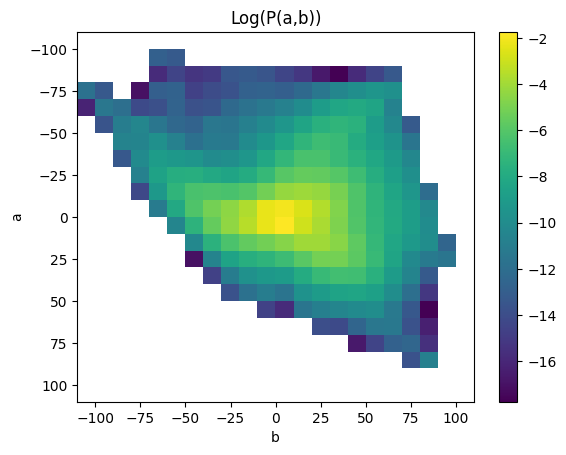

In [ ]:
a = dataset_ab[:,0,:,:].reshape(1,-1)
a = torch.squeeze(a).numpy()
b = dataset_ab[:,1,:,:].reshape(1,-1)
b = torch.squeeze(b).numpy()

# Define the limits for the x and y axes
x_min, x_max = -110, 110
y_min, y_max = -110, 110

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(a, b, bins=22, range=[[x_min, x_max], [y_min, y_max]])

print(xedges)

print(len(x), '\n')
print(np.sum(hist), '\n')
print('Diff: ', len(x) - np.sum(hist))

hist_log = np.log((hist/np.sum(hist)))

# Plot the histogram in logarithmic scale
plt.imshow(hist_log, interpolation='nearest', extent=[x_min, x_max, y_max, y_min], origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('b')
plt.ylabel('a')
plt.title('Log(P(a,b))')
plt.show()

We now want to map each upperleft corner of a nonzero bin to its bin number

In [ ]:
Q = np.sum(np.isfinite(hist_log))
print("With our dataset we get Q = ", Q)

With our dataset we get Q =  246


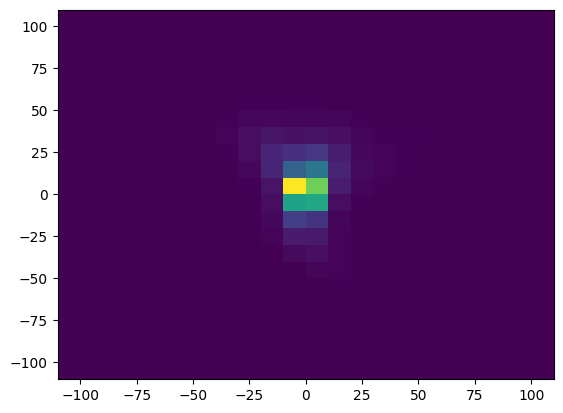

In [ ]:
hist_obj = plt.hist2d(a, b, bins=22, range=[[x_min, x_max], [y_min, y_max]])

In [ ]:
#Keep track of where the grid points are
positions = []
indeces = []

index = 0

for i in range(len(hist_obj[1][:-1])):
  for j in range(len(hist_obj[2][:-1])):
    if hist_obj[0][i, j] > 0:
      positions.append((i,j))
      indeces.append(index)
      index += 1

dictionary = dict(zip(positions, indeces))

## Store new dataset

In [ ]:
#Create ground truth Z_label

output_tensor = torch.zeros(50000, 1, 32, 32)

for image_number in range(dataset_ab.shape[0]):
  if image_number % 100 == 0:
    print("Image_nUmber : ", image_number)
  Z_image = np.zeros([1, 32, 32])
  image = dataset_ab[image_number, :, :, :]
  for i in range(32):
    for j in range(32):
      couple = tuple(torch.Tensor.tolist(torch.Tensor.int(image[:, i,j] // 10 + 11)))
      index = dictionary[couple]
      Z_image[0, i, j] = index
  output_tensor[image_number, :, :, :] = torch.tensor(Z_image)

Image_nUmber :  0
Image_nUmber :  100
Image_nUmber :  200
Image_nUmber :  300
Image_nUmber :  400
Image_nUmber :  500
Image_nUmber :  600
Image_nUmber :  700
Image_nUmber :  800
Image_nUmber :  900
Image_nUmber :  1000
Image_nUmber :  1100
Image_nUmber :  1200
Image_nUmber :  1300
Image_nUmber :  1400
Image_nUmber :  1500
Image_nUmber :  1600
Image_nUmber :  1700
Image_nUmber :  1800
Image_nUmber :  1900
Image_nUmber :  2000
Image_nUmber :  2100
Image_nUmber :  2200
Image_nUmber :  2300
Image_nUmber :  2400
Image_nUmber :  2500
Image_nUmber :  2600
Image_nUmber :  2700
Image_nUmber :  2800
Image_nUmber :  2900
Image_nUmber :  3000
Image_nUmber :  3100
Image_nUmber :  3200
Image_nUmber :  3300
Image_nUmber :  3400
Image_nUmber :  3500
Image_nUmber :  3600
Image_nUmber :  3700
Image_nUmber :  3800
Image_nUmber :  3900
Image_nUmber :  4000
Image_nUmber :  4100
Image_nUmber :  4200
Image_nUmber :  4300
Image_nUmber :  4400
Image_nUmber :  4500
Image_nUmber :  4600
Image_nUmber :  4700
Imag

In [ ]:
#Save dataset so we won't have to compute it again
serialized_dataset_path = '/content/drive/MyDrive/CIFAR10/train.pkl'
pickle.dump(train, open("df.pkl", "wb"))

pickle.dump(test, open("df_test.pkl", "wb"))

In [ ]:
!cp df.pkl gdrive/MyDrive/CIFAR10

In [ ]:
!cp df_test.pkl gdrive/MyDrive/CIFAR10

In [ ]:
#Convert to tensor form --> represents the features as one tensor 4D [index, 3, 32, 32]
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_Z = torch.Tensor.int(output_tensor)

#Set up new dataset
N_images = 40000
train = data_utils.TensorDataset(dataset_l[: N_images], dataset_Z[: N_images])
test = data_utils.TensorDataset(dataset_l[N_images:], dataset_Z[N_images: ])

## Load new dataset

In [ ]:
objects = []
with (open("/content/gdrive/MyDrive/CIFAR10/df.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

with (open("/content/gdrive/MyDrive/CIFAR10/df_test.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break


In [ ]:
train = objects[0]
test = objects[1]

## Computation of $\vec{w}$

In [ ]:
#Store indeces as tensor

position_tensor = torch.zeros([len(hist_obj[1][:-1]), len(hist_obj[2][:-1])] )
for position, index in zip(positions, indeces):
  position_tensor[position[0], position[1]] = index

position_tensor = torch.Tensor.int(position_tensor)

auxiliary_tensor = torch.tensor([i for i in range(Q)], requires_grad = False)
auxiliary_tensor = torch.unsqueeze(auxiliary_tensor, 0)
auxiliary_tensor = torch.unsqueeze(auxiliary_tensor, 0)
auxiliary_tensor = torch.Tensor.repeat(auxiliary_tensor, [32, 32, 1])
auxiliary_tensor = torch.unsqueeze(auxiliary_tensor, 0)
auxiliary_tensor = torch.permute(auxiliary_tensor, [0,3,1,2])

In [ ]:
l = .5                                  # lambda
p = np.ndarray.flatten(hist_obj[0])
p = p[p > 0.]                           # p is a 1D array with the non-zero probabilities
Q = len(p)

w = 1 / ((1-l)*p + l/Q)
w = w / np.dot(w , p)

## Define loss function

$L_{cl} = - \sum_{h,w, q} v(Z_{hw}) Z_{h,w,q}\log(\hat{Z}_{hwq})$, $v(Z_{hw}) = w_{q^*}$, where $q^*$ is the index of the corresponding bin. We encode the ground truth $Z_{h,w,q}$ using one-hot-encoding.

*Reminder: Z has the shape of (1, h, w, q)*.

## Training (special loss)

Potremmo salvare un'unica volta il dataset nella forma (ndati, 1, 32, 32). Per la loss dobbiamo fare una cross entropy tra i due

In [ ]:
#Data loader
batch_size = 200
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [ ]:
w = torch.tensor(w)
w = w.clone().detach()

def mylog(tensor):
  eps = 1e-50
  new_tensor = torch.clone(tensor)
  new_tensor[tensor <= 0.] = eps
  return torch.log(new_tensor)

<ipython-input-57-621382bdcf67>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(w)


In [ ]:
class network_model(nn.Module):
  def __init__(self):
    super(network_model, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6]) #first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():
      param.requires_grad = False


    # define our layers on top of resnet
    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=4),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, Q, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(Q),
      nn.ReLU(),
    )

  def forward(self, input):
    y = self.resnet_base(input) #first go through resnet
    z = self.cnn_next(y)        #then go through our layers
    return z

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, Z_pred, Z_truth):
      nData = Z_pred.shape[0]
      v = w[Z_truth].view(nData, 32, 32)

      zeros = torch.zeros(nData, Q, 32, 32)
      one_hot = zeros.scatter(1, Z_truth.type(torch.int64), v)

      l = -torch.sum(v*torch.sum(one_hot * mylog(Z_pred), dim = 1), [0,1,2])

      return l

In [ ]:
network = network_model() #CNN
loss = nn.CrossEntropyLoss()       #We begin with a simple MSE loss function
optim = torch.optim.Adam(network.parameters(), lr=1e-4, weight_decay=0.0)

In [ ]:
losses_train = []
losses_val = []

epochs = 50
patience = 8 #how many epochs of non decreasing validation we accept
min_val = 0 #minimum validation loss (initialized to a meaningless value - we will update it at the first epoch)
softmax = nn.Softmax(dim = 1)

with torch.autograd.set_detect_anomaly(False):
  for epoch in range(epochs):
    print("Epoch ", epoch)
    network.train() #Set it up for training
    i = 0
    ls = []
    for features, labels in train_loader:
      predictions = network(features)
      predictions_sm = softmax(predictions)

      v = w[labels].view(batch_size, 32, 32)
      zeros = torch.zeros(batch_size, Q, 32, 32, dtype = torch.float64)

      one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = torch.unsqueeze(v, 1))
      L = loss(predictions_sm, one_hot)
      ls.append(L.item())

      optim.zero_grad()
      L.backward()
      optim.step()

      if i%20 == 0:
        print("Loss at iteration ",  i , " is ", L.item())
      i += 1
    losses_train.append(mean(ls))

    #Validation loss
    network.eval()
    with torch.no_grad():
      val_batches = []
      for features, labels in test_loader:
        prediction_val = network(features)
        prediction_val_sm = softmax(prediction_val.clone())

        v = w[labels].view(batch_size, 32, 32)
        zeros = torch.zeros(batch_size, Q, 32, 32, dtype = torch.float64)

        one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = torch.unsqueeze(v, 1))

        val_loss = loss(prediction_val_sm, one_hot)
        val_batches.append(val_loss.item())
      print("At epoch ", epoch, " validation loss ", mean(val_batches))
      losses_val.append(mean(val_batches))

    #Early stopping
    if epoch == 1:
      min_val = mean(val_batches)

    if mean(val_batches) < min_val:
      min_val = mean(val_batches)

    #Early stopping: break if no new minimum was reached in the last *patience* epochs

    if epoch >= patience:
        condition = 0
        for index in range(patience):
          if losses_val[-(index + 1)] > min_val:
            condition += 1
        if condition == patience:
          print("Early stopping!")
          break

Epoch  0
Loss at iteration  0  is  6.359157626721423e-08
Loss at iteration  20  is  6.784163816128598e-08
Loss at iteration  40  is  7.725445569654336e-08
Loss at iteration  60  is  8.366441493190816e-08
Loss at iteration  80  is  6.278760866897153e-08
Loss at iteration  100  is  2.6166216673177865e-07
Loss at iteration  120  is  1.3008213315677793e-07
Loss at iteration  140  is  1.9076777853611785e-07
Loss at iteration  160  is  6.943666216542439e-08
Loss at iteration  180  is  6.420888368150975e-08


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 4